In [1]:
import numpy as np
import pandas as pd
import math
import torch
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from numpy import unravel_index

In [47]:
N = 641
f = 128

subject_index = "1"
df = pd.read_csv(f'./EEG_Subject{subject_index}.csv', header=None)
ydf = pd.read_csv(f'./Stimulus_Subject{subject_index}.csv', header=None)
# sample frequency = 128 Hz
# samples per trail = 128 * 5 = 640
x = df.to_numpy()
y = ydf.to_numpy()[0]

In [48]:
x.shape, y.shape

((14, 187392), (187392,))

In [49]:
# analyzing data
tmp = y[y!=0]
last = 0
for i in range(len(y)):
    if y[i] != y[i-1]:
        size = i-last
        print(size)
        last = i

1029
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
1692
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
1613
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
1788
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
1588
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
3865
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
2019
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
1631
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
1623
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
1542
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
641
767
64

In [50]:
# restructring data
filtered_x = x[:,y!=0]
filtered_y = y[y!=0]
aggregate_y = np.ndarray(125)
for i in range(125):
    aggregate_y[i] = filtered_y[i*641]

def split_into_trials(x, trial_size):
    trials = torch.from_numpy(x[:,y!=0]).unfold(1, trial_size, trial_size).permute((1,0,2)).numpy()
    return trials
trials = split_into_trials(x, 641)

# Plotting

In [51]:
def plot_trial(data: np.ndarray) -> None:
    plt.plot(data);

# Normaliziation & CAR

In [52]:
def normalize(data: np.ndarray) -> np.ndarray:
    normal = data.copy()
    means = data.mean(axis=1)
    # stds = data.std(axis=1)
    normal = ((normal.transpose() - means)).transpose()

    return normal

In [53]:
def car_filter(trial: np.ndarray) -> np.ndarray:
    sum_signals = trial.sum(axis=0) / trial.shape[0]
    filtered_eeg_data = trial.copy() - sum_signals
    return filtered_eeg_data

In [54]:
trials_filtered = split_into_trials(car_filter(normalize(x)), 641)
trials_filtered2 = split_into_trials(normalize(car_filter(x)), 641)

def apply_function_per_trial(trials: np.ndarray, f, new_size=None) -> np.ndarray:
    if new_size == None:
        new_size = trials.shape
    f_applied = np.ndarray(new_size)
    for trial in range(125):
        for electrode in range(14):
            f_applied[trial, electrode] = f(trials[trial, electrode])
    
    return f_applied

In [55]:
((trials_filtered - trials_filtered2) ** 2).sum() / 1121750
# car then normal OR normal then car are near identical (order doesn't matter)

4.909725743871802e-19

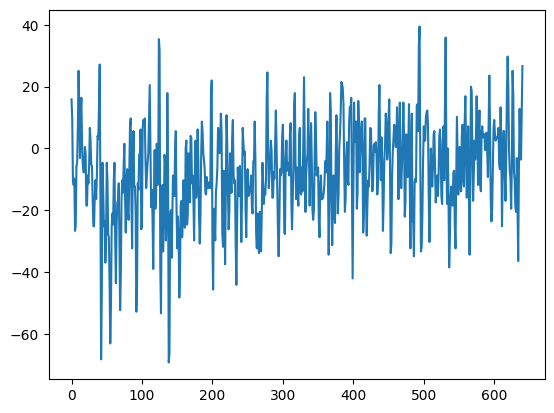

In [56]:
plt.plot(normalize(x)[6,:641]);

# DFT

In [57]:
def get_dft(trial: np.ndarray) -> np.ndarray:
    return np.absolute(np.fft.fft(trial))

def plot_dft(data: np.ndarray, window=None) -> None:
    res = get_dft(data)
    if window == None:
        plt.plot(res);
    else:
        plt.plot(res[window]);

In [58]:
trials_dft = apply_function_per_trial(trials_filtered, get_dft, (125,14,641))

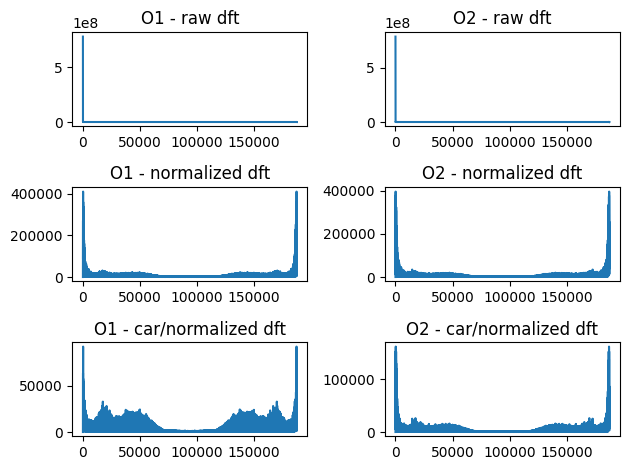

In [59]:
fig, ax = plt.subplots(3, 2)

plt.subplot(3,2,1)
plot_dft(x[6])
ax[0,0].set_title("O1 - raw dft")

plt.subplot(3,2,3)
plot_dft(normalize(x)[6])
ax[1,0].set_title("O1 - normalized dft")

plt.subplot(3,2,5)
plot_dft(car_filter(normalize(x))[6])
ax[2,0].set_title("O1 - car/normalized dft")

plt.subplot(3,2,2)
plot_dft(x[7])
ax[0,1].set_title("O2 - raw dft")

plt.subplot(3,2,4)
plot_dft(normalize(x)[7])
ax[1,1].set_title("O2 - normalized dft")

plt.subplot(3,2,6)
plot_dft(car_filter(normalize(x))[7])
ax[2,1].set_title("O2 - car/normalized dft")

fig.tight_layout()

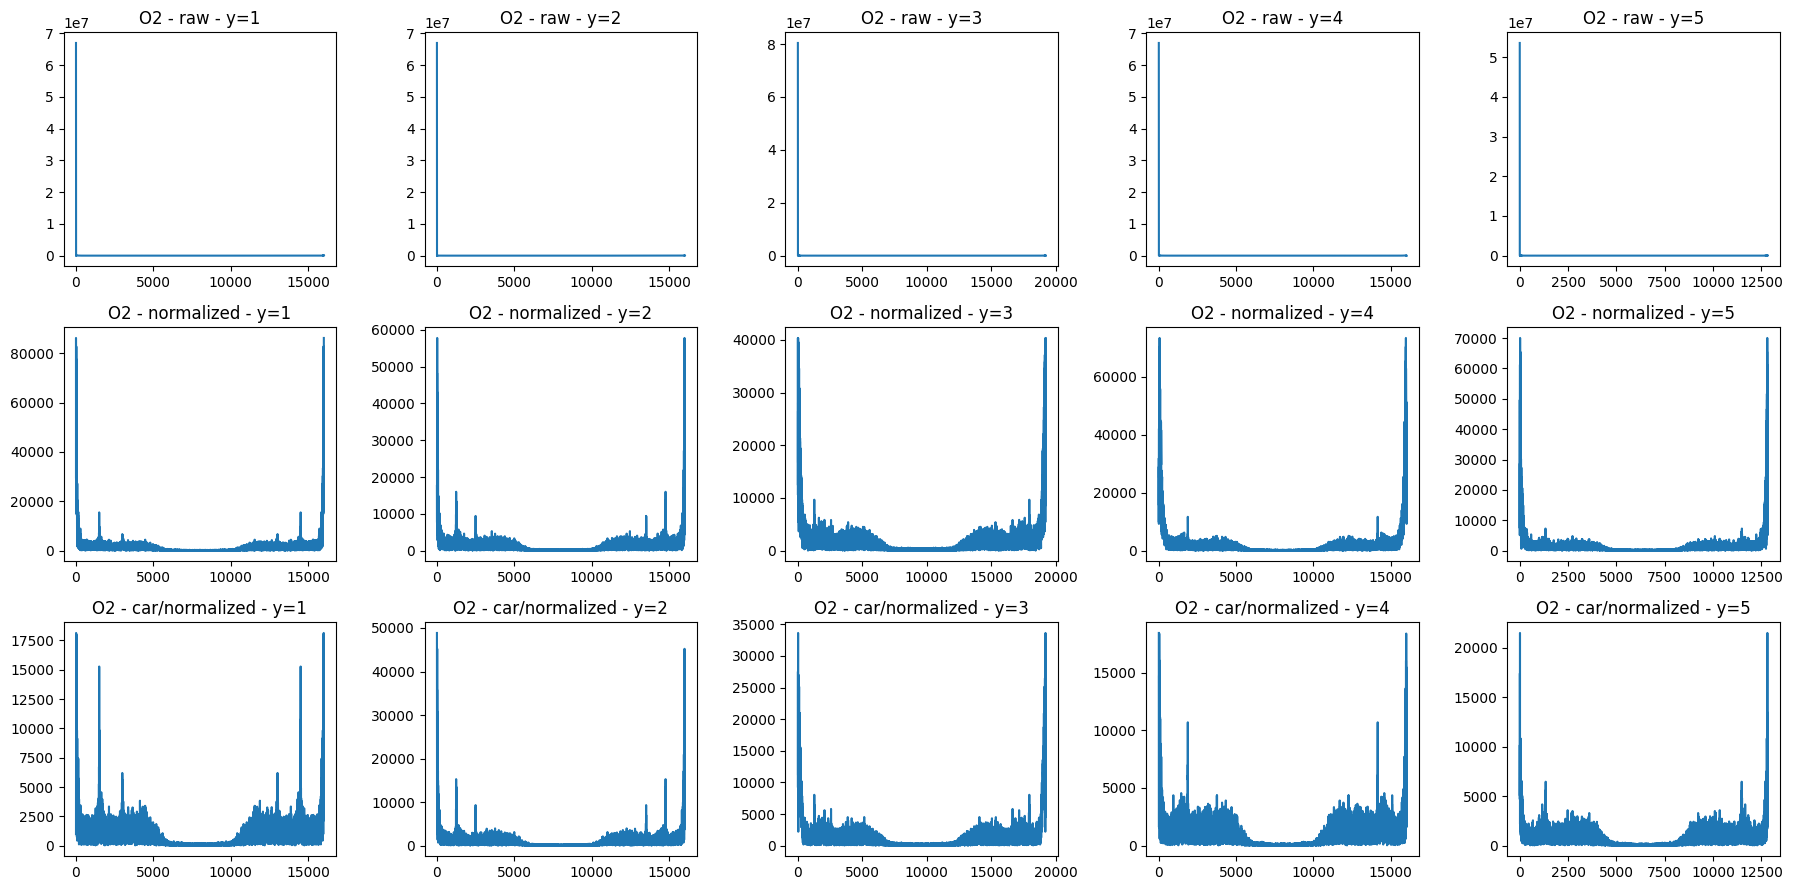

In [60]:
electrode = 7
electrode_name = "O2"

fig, ax = plt.subplots(3, 5, figsize=(18, 9))

for row in range(1,4):

    for col in range(1,6):
        plt.subplot(3,5, (row-1)*5 + col)

        if row == 1:
            row_title = "raw"
            plot_dft(x[electrode, y==col])
        elif row == 2:
            row_title = "normalized"
            plot_dft(normalize(x)[electrode, y==col])
        elif row == 3:
            row_title = "car/normalized"
            plot_dft(car_filter(normalize(x))[electrode, y==col])

        ax[row-1,col-1].set_title(f"{electrode_name} - {row_title} - y={col}")

fig.tight_layout()

# Extracting Frequency Component

In [61]:
def get_component_index(freq: float, N:int=N, sampling_rate:int=f) -> float:
    freq_bins = np.fft.fftfreq(N, d=1/sampling_rate)
    for i in range(len(freq_bins)):
        if freq == freq_bins[i]:
            return i
        elif freq < freq_bins[i]:
            return i-.5

    raise Exception("Invalid frequency component")

def get_component(freq: float, freqs: np.ndarray, N:int=N, sampling_rate:int=f) -> float:
    i = get_component_index(freq, N, sampling_rate)
    if (i%1 == 0):
        i = int(i)
        return freqs[i-1 : i+2].sum() / 3
    else:
        i = int(i)
        return freqs[i : i+2].sum() / 2
    
def get_component_window(freq: float, freqs: np.ndarray, freq_window_size:int=2, N:int=N, sampling_rate:int=f) -> np.ndarray:
    i = get_component_index(freq, N, sampling_rate)
    i = int(i)
    return freqs[i-freq_window_size : i+freq_window_size+1]

# 12 -> 60,61
# 10 -> 50, 51
# 8.57 -> 42, 43
# 7.5 -> 37, 38
# 6.66 -> 33, 34

In [62]:
def get_components_val_from_dft(freqs:np.ndarray, components:list[float]=[6.66, 7.5, 8.57, 10, 12]) -> np.ndarray:
    components_val = []
    for component in components:
        components_val.append(get_component(component, freqs))

    return np.array(components_val)

def get_components_val(trial: np.ndarray, components:list[float]=[6.66, 7.5, 8.57, 10, 12]) -> np.ndarray:
    freqs = get_dft(trial)
    return get_components_val_from_dft(freqs, components)

def get_components_val_from_dft_windowed(freqs: np.ndarray, window_size:int=2, components:list[float]=[6.66, 7.5, 8.57, 10, 12]) -> np.ndarray:
    components_val = np.array([])
    for component in components:
        components_val = np.append(components_val, get_component_window(component, freqs, window_size))

    return components_val

def get_components_val_windowed(trial: np.ndarray, window_size:int=2, components:list[float]=[6.66, 7.5, 8.57, 10, 12]) -> np.ndarray:
    freqs = get_dft(trial)
    return get_components_val_from_dft_windowed(freqs, window_size, components)

def get_highest_val(components_val: np.ndarray) -> int:
    return int(components_val.argmax())

def estimate_freq(trial: np.ndarray, components:list[float]=[12, 10, 8.57, 7.5, 6.66]) -> int:
    components_val = get_components_val(trial, components)
    return get_highest_val(components_val)

def estimate_freq_from_dft(freqs: np.ndarray, components:list[float]=[12, 10, 8.57, 7.5, 6.66]) -> int:
    components_val = get_components_val_from_dft(freqs, components)
    return get_highest_val(components_val)

# Visualize frequency components

In [63]:
def plot_components(components_val: list[int], components:list[float]=[6.66,7.5,8.57,10,12]) -> None:
    components = [get_component_index(component) for component in components]
    plt.scatter(components, components_val, c="r");

# 12 -> 60,61
# 10 -> 50, 51
# 8.57 -> 42, 43
# 7.5 -> 37, 38
# 6.66 -> 33, 34

In [64]:
trial_num = 0

(1, 2.0)

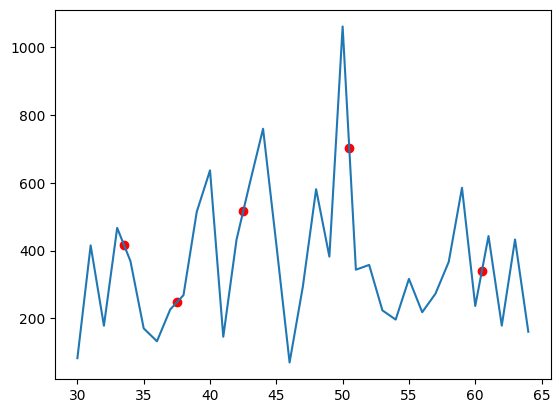

In [65]:
trial_num += 1
window = (30, 65)

plt.plot(list(range(window[0],window[1])), trials_dft[trial_num, 7, window[0]:window[1]])
plot_components(get_components_val_from_dft(trials_dft[trial_num,7]))
trial_num, aggregate_y[trial_num]

# Computing Methods

In [66]:
def acc_fn(y: np.ndarray, y_pred: np.ndarray) -> float:
    return (y == y_pred).sum() / len(y)

### Method 1

1- normalize/car filter

2- dft

3- sample dft at components

4- find max component

In [67]:
res_o1 = np.ndarray(125)
res_o2 = np.ndarray(125)
res_avg = np.ndarray(125)
for i in range(125):
    res_o1[i] = estimate_freq_from_dft(trials_dft[i, 6]) # o1
    res_o2[i] = estimate_freq_from_dft(trials_dft[i, 7]) # o2
    res_avg[i] = estimate_freq_from_dft((trials_dft[i, 6] + trials_dft[i, 7]) / 2) # o1 & o2

res_o1 += 1
res_o2 += 1
res_avg += 1

acc_o1 = acc_fn(aggregate_y, res_o1)
acc_o2 = acc_fn(aggregate_y, res_o2)
acc_avg = acc_fn(aggregate_y, res_avg)
print(f"O1: {acc_o1*100}% | O2: {acc_o2*100}% | O_avg: {acc_avg*100}%")

O1: 54.400000000000006% | O2: 65.60000000000001% | O_avg: 61.6%


### Method 2

1- normalize / car filter

2- dft

3- smaple at components / 

4- run KNN with k=1-30

In [68]:
# narrow spectrum to only 5 components
# window = (30, 65)
window = (5, 189)
# trials_components = apply_function_per_trial(trials_dft, get_components_val_from_dft, (125,14,5))
trials_components = apply_function_per_trial(trials_dft, lambda x: x[window[0]: window[1]], (125,14,window[1]-window[0]))
# trials_components = apply_function_per_trial(trials_dft, get_components_val_from_dft_windowed, (125,14,25))

1: 89.60000000000001
2: 86.4
3: 89.60000000000001
4: 91.2
5: 89.60000000000001
6: 92.0
7: 91.2
8: 90.4
9: 92.80000000000001
10: 88.8
11: 92.0
12: 94.39999999999999
13: 92.0
14: 94.39999999999999
15: 92.80000000000001
16: 94.39999999999999
17: 92.0
18: 93.60000000000001
19: 95.19999999999999
20: 96.0
21: 93.60000000000001
22: 94.39999999999999
23: 93.60000000000001
24: 93.60000000000001
25: 93.60000000000001
26: 92.0
27: 92.0
28: 92.0
29: 92.0
Max K -> 20 : 0.96


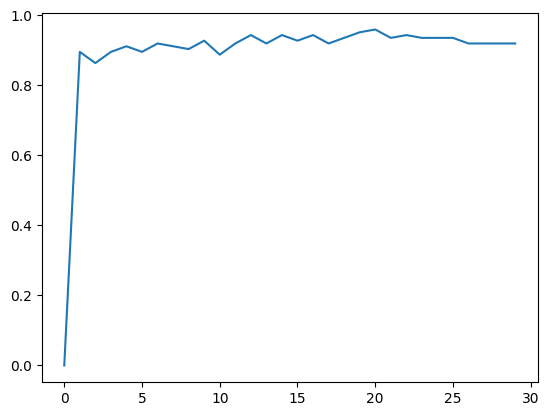

In [150]:
# try using components only instead of all data
components_window_size = 100

electrode = 7
acc_k = np.zeros(30)
for k in range(1,30):
    res = np.ndarray(125)
    for i in range(125):
        neigh = KNeighborsClassifier(n_neighbors=k) # create classifier with k

        # drop ith trial
        trials_dropped = np.append(trials_components[:i], trials_components[i+1:], 0)
        y_dropped = np.append(aggregate_y[:i], aggregate_y[i+1:])

        neigh.fit(trials_dropped[:,electrode,:], y_dropped)
        res[i] = neigh.predict(trials_components[[i],electrode])[0]

        # neigh.fit((trials_dropped[:,6,:] + trials_dropped[:,7,:]) / 2, y_dropped)
        # res[i] = neigh.predict((trials_components[[i],6] + trials_components[[i],7]) / 2)[0]

        # neigh.fit(trials_dropped[:,6:8,:].reshape(124,components_window_size*2), y_dropped)
        # res[i] = neigh.predict(trials_components[[i],6:8].reshape(1,components_window_size*2))[0]

        # neigh.fit(trials_dropped[:,:,:].reshape(124,components_window_size*14), y_dropped)
        # res[i] = neigh.predict(trials_components[[i],:].reshape(1,components_window_size*14))[0]

    acc = acc_fn(aggregate_y, res)
    acc_k[k] = acc
    print(f"{k}: {acc*100}")

print(f"Max K -> {acc_k.argmax()} : {acc_k.max()}")
plt.plot(acc_k);

In [69]:
# try using components only instead of all data
def find_max_k(trials_components, aggregate_y, electrode=7):
    components_window_size = trials_components.shape[2]

    acc_k = np.zeros(30)
    for k in range(20,25):
        res = np.ndarray(125)
        for i in range(125):
            neigh = KNeighborsClassifier(n_neighbors=k) # create classifier with k

            # drop ith trial
            trials_dropped = np.append(trials_components[:i], trials_components[i+1:], 0)
            y_dropped = np.append(aggregate_y[:i], aggregate_y[i+1:])

            # neigh.fit(trials_dropped[:,electrode,:], y_dropped)
            # res[i] = neigh.predict(trials_components[[i],electrode])[0]

            # neigh.fit((trials_dropped[:,6,:] + trials_dropped[:,7,:]) / 2, y_dropped)
            # res[i] = neigh.predict((trials_components[[i],6] + trials_components[[i],7]) / 2)[0]

            # neigh.fit(trials_dropped[:,6:8,:].reshape(124,components_window_size*2), y_dropped)
            # res[i] = neigh.predict(trials_components[[i],6:8].reshape(1,components_window_size*2))[0]

            neigh.fit(trials_dropped[:,:,:].reshape(124,components_window_size*14), y_dropped)
            res[i] = neigh.predict(trials_components[[i],:].reshape(1,components_window_size*14))[0]

        acc = acc_fn(aggregate_y, res)
        acc_k[k] = acc

    return acc_k.argmax(), acc_k.max()

In [71]:
file_name = "res_o2_subject1.txt"
with open(file_name, "x") as f:
    f.write("")

res = []

max_window_start, min_window_end = 30, 65
acc_k_window = np.zeros((320, 320, 2))
for window_start in range(10, max_window_start):
    for window_last in range(min_window_end, 320): # don't exceed 320
        window = (window_start, window_last)
        trials_components = apply_function_per_trial(trials_dft, lambda x: x[window[0]: window[1]], (125,14,window[1]-window[0]))

        k, acc = find_max_k(trials_components, aggregate_y, 7)
        tmp = f"{window_start}:{window_last} -> K: {k} | acc: {acc*100}"
        print(tmp)
        res.append(tmp)

        acc_k_window[window_start, window_last, 0] = k
        acc_k_window[window_start, window_last, 1] = acc

        if (window_last > min_window_end + 10):
            if (acc_k_window[window_start, window_last-5:window_last, 1].mean() < acc-0.1):
                break
            elif (acc_k_window[window_start, window_last-10:window_last, 1] == acc).all():
                break

res = "\n".join(res)
with open(file_name, "w") as f:
    f.write(res)

best_start, best_end, _ = unravel_index(acc_k_window[:,:,1].argmax(), (320,320,1))
print(f"Max Window/k -> Window Start: {best_start} | Window Last: {best_end} | K: {acc_k_window[best_start, best_end, 0]} | acc: {acc_k_window[best_start, best_end, 1]}")

8:65 -> K: 20 | acc: 55.2
8:66 -> K: 22 | acc: 56.00000000000001
8:67 -> K: 24 | acc: 55.2
8:68 -> K: 22 | acc: 60.8
8:69 -> K: 23 | acc: 63.2
8:70 -> K: 22 | acc: 63.2
8:71 -> K: 23 | acc: 62.4
8:72 -> K: 23 | acc: 61.6
8:73 -> K: 24 | acc: 59.199999999999996
8:74 -> K: 23 | acc: 59.199999999999996
8:75 -> K: 21 | acc: 57.599999999999994
8:76 -> K: 24 | acc: 68.0
8:77 -> K: 23 | acc: 67.2
8:78 -> K: 24 | acc: 66.4
8:79 -> K: 21 | acc: 67.2
8:80 -> K: 21 | acc: 67.2
8:81 -> K: 22 | acc: 71.2
8:82 -> K: 20 | acc: 69.6
8:83 -> K: 22 | acc: 70.39999999999999
8:84 -> K: 23 | acc: 69.6
8:85 -> K: 20 | acc: 68.8
8:86 -> K: 24 | acc: 74.4
8:87 -> K: 21 | acc: 75.2
8:88 -> K: 21 | acc: 75.2
8:89 -> K: 20 | acc: 74.4
8:90 -> K: 21 | acc: 72.8
8:91 -> K: 21 | acc: 74.4
8:92 -> K: 24 | acc: 73.6
8:93 -> K: 23 | acc: 72.8
8:94 -> K: 24 | acc: 75.2
8:95 -> K: 22 | acc: 74.4
8:96 -> K: 24 | acc: 72.8
8:97 -> K: 24 | acc: 73.6
8:98 -> K: 24 | acc: 72.0
8:99 -> K: 23 | acc: 72.0
8:100 -> K: 21 | acc: 

KeyboardInterrupt: 